In [220]:
from tqdm import tqdm 
import pandas as pd 

airports     = pd.read_csv('../../data/us_large_airports.csv')
airports     = airports[airports['type'] == 'large_airport']
big_airports =  list(set(airports['iata_code'].dropna().unique()))[:35]  #{'ATL', 'JFK', 'LAX', 'ORD'}

flights  = pd.read_csv('../../data/Airports2.csv', usecols=['Origin_airport', 'Destination_airport', 'Origin_city', 'Destination_city', 'Fly_date'])
flights = flights[flights.apply(lambda x: (x['Origin_airport'] in big_airports) and (x['Destination_airport'] in big_airports), axis=1)]
flights  = flights.drop_duplicates()

flights['Fly_date'] = pd.to_datetime(flights['Fly_date'])               

flights.sort_values(by=['Fly_date'], inplace=True)

flights.drop(columns=['Origin_city', 'Destination_city'], inplace=True)
flights.reset_index(drop=True, inplace=True)

T = flights['Fly_date'].unique()
date_encoding = {v:i for i, v in enumerate(T)}
airport_encoding = {airport:i for i, airport in enumerate(big_airports)}

## Node Positioning

In [248]:
len(big_airports), matrix.shape

(35, (31, 31))

In [249]:
# origins = flights['Origin_airport'].unique()
# destinations = flights['Destination_airport'].unique()

matrix = pd.DataFrame(0, index=big_airports, columns=big_airports)
for i in tqdm(range(len(flights))):
    row = flights.iloc[i]
    matrix.loc[row['Origin_airport'], row['Destination_airport']] += 1

100%|██████████| 126739/126739 [00:15<00:00, 8431.60it/s]


In [293]:
from sklearn.cluster import AgglomerativeClustering
sc = AgglomerativeClustering(n_clusters=5)
clusters = sc.fit_predict(matrix)

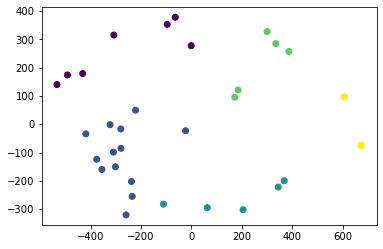

In [294]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt 

pca = PCA(n_components=2)

reduced = pca.fit_transform(matrix)
reduced = pd.DataFrame(reduced)

plt.scatter(reduced[0], reduced[1], c=clusters);

In [295]:
clusters

clusters_dict = dict(zip(big_airports,clusters))

In [296]:
#Sort big airports by cluster
# big_airports = list(big_airports)
big_airports.sort(key=lambda x: clusters_dict[x])

In [285]:
clusters_dict

{'BNA': 0,
 'SAN': 0,
 'SDF': 1,
 'SMF': 1,
 'ADW': 1,
 'BOS': 0,
 'ONT': 1,
 'ORD': 0,
 'JAX': 2,
 'MSP': 0,
 'CLT': 0,
 'IAD': 0,
 'MDW': 0,
 'AUS': 1,
 'SAV': 2,
 'SEA': 0,
 'FAI': 1,
 'RDU': 2,
 'LGA': 0,
 'ANC': 1,
 'SLC': 0,
 'RNO': 1,
 'RSW': 1,
 'LAX': 0,
 'PHL': 0,
 'SAT': 1,
 'TPA': 0,
 'SYR': 2,
 'PWM': 2,
 'DCA': 0,
 'CLE': 0,
 'DFW': 0,
 'MCI': 0,
 'MEM': 0,
 'DTW': 0}

In [284]:
matrix.index

Index(['BNA', 'SAN', 'SDF', 'SMF', 'ADW', 'BOS', 'ONT', 'ORD', 'JAX', 'MSP',
       'CLT', 'IAD', 'MDW', 'AUS', 'SAV', 'SEA', 'FAI', 'RDU', 'LGA', 'ANC',
       'SLC', 'RNO', 'RSW', 'LAX', 'PHL', 'SAT', 'TPA', 'SYR', 'PWM', 'DCA',
       'CLE', 'DFW', 'MCI', 'MEM', 'DTW'],
      dtype='object')

In [283]:
big_airports

['BNA',
 'SAN',
 'BOS',
 'ORD',
 'MSP',
 'CLT',
 'IAD',
 'MDW',
 'SEA',
 'LGA',
 'SLC',
 'LAX',
 'PHL',
 'TPA',
 'DCA',
 'CLE',
 'DFW',
 'MCI',
 'MEM',
 'DTW',
 'SDF',
 'SMF',
 'ADW',
 'ONT',
 'AUS',
 'FAI',
 'ANC',
 'RNO',
 'RSW',
 'SAT',
 'JAX',
 'SAV',
 'RDU',
 'SYR',
 'PWM']

## Flights for airport grid

In [214]:
time_steps = 12

In [215]:
flights['Fly_date'].replace(date_encoding, inplace=True)

In [216]:
flights['Origin_airport']      = flights.apply(lambda x: "%s_%s" % (x['Origin_airport'],      x['Fly_date']), axis=1)
flights['Destination_airport'] = flights.apply(lambda x: "%s_%s" % (x['Destination_airport'], x['Fly_date']+1), axis=1)

filtered = flights[flights['Fly_date'].apply(lambda x: x in range(time_steps))]
filtered.columns = ['origin', 'destination', 'count']
filtered.to_csv('flights.csv', index=False)

## Grid Positioning 

$ (t*c_x, i*c_y)$ where $i \in [0, N]$  and $t \in [0, T]$ such that $N$ is number of nodes (e.g. airports) and $T$ is time (e.g. days). 

$c_x$ and $c_y$ are constants that define the distance distance from origin $(0, 0)$ as well as between other nodes. 

In [292]:
locs = []

# width = 960
# height = 600

c_x = 100
c_y = 20
# for k in airport_encoding:
    # i = airport_encoding[k]
for i, k in enumerate(big_airports):
    for t in range(time_steps+1): #list(date_encoding.values()):
        locs.append(["%s_%s" % (k,t), (t+1)*c_x, (i+1)*c_y, clusters_dict[k]])

locs_df = pd.DataFrame(locs)
locs_df.columns = ['iata', 'latitude', 'longitude', 'cluster']
# locs_df['latitude']  = locs_df['latitude']
# locs_df['latitude']  = locs_df['latitude']
locs_df.to_csv('grid_locs.csv', index=False)

In [291]:
clusters_dict[k]

2